In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
img_path="/content/drive/MyDrive/Chess scanner Project/Sample_Chessboard.png"
image=cv2.imread(img_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

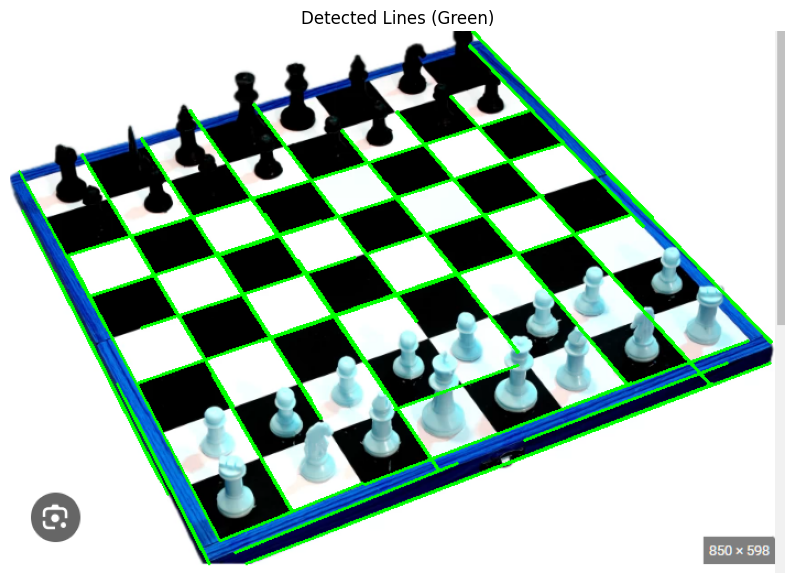

In [ ]:

# Step 1: Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Apply Gaussian blur to reduce noise (optional but can help in corner detection)
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Step 3: Apply adaptive thresholding to enhance edges and contrasts
adaptive_threshold = cv2.adaptiveThreshold(gray_blurred, 255,
                                          cv2.ADAPTIVE_THRESH_MEAN_C,
                                          cv2.THRESH_BINARY, 11, 2)

# Show the adaptive thresholded image (for debugging)
plt.figure(figsize=(8, 8))
plt.imshow(adaptive_threshold, cmap='gray')
plt.title("Adaptive Thresholding")
plt.axis('off')
plt.show()

# Step 4: Chessboard pattern size: (7, 7) for an 8x8 chessboard (7 internal corners)
pattern_size = (7, 7)  # (columns-1, rows-1)

# Step 5: Find the chessboard corners
ret, corners = cv2.findChessboardCorners(adaptive_threshold, pattern_size, None)

# If corners are found, refine their position and apply perspective transformation
if ret:
    # Refine the corner positions
    corners = cv2.cornerSubPix(gray_blurred, corners, (11, 11), (-1, -1),
                               criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))

    # Draw the corners on the image
    img_with_corners = image.copy()
    cv2.drawChessboardCorners(img_with_corners, pattern_size, corners, ret)

    # Show the image with the detected corners
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
    plt.title("Detected Corners")
    plt.axis('off')
    plt.show()

    # Step 6: Apply perspective transform to obtain a 2D chessboard
    pts1 = np.float32([corners[0], corners[6], corners[49], corners[55]])  # Choose the corners (top-left, top-right, bottom-left, bottom-right)
    width, height = 400, 400  # Desired output size for the transformed chessboard
    pts2 = np.float32([[0, 0], [width-1, 0], [0, height-1], [width-1, height-1]])

    # Calculate the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(pts1, pts2)

    # Perform the perspective warp
    warped_image = cv2.warpPerspective(image, matrix, (width, height))

    # Show the warped chessboard (perspective corrected)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title("Warped Chessboard")
    plt.axis('off')
    plt.show()

else:
    print("Chessboard corners not found")
    # Show the adaptive thresholded image if no corners found
    plt.figure(figsize=(8, 8))
    plt.imshow(adaptive_threshold, cmap='gray')
    plt.title("Thresholded Image (No Corners Found)")
    plt.axis('off')
    plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_chessboard(image_path):
    # Step 1: Load the image
    img = cv2.imread(image_path)

    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Step 4: Detect edges using Canny edge detector
    edges = cv2.Canny(blurred, 100, 200)

    # Step 5: Find contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 6: Find the largest contour, which should correspond to the chessboard
    max_contour = max(contours, key=cv2.contourArea)

    # Step 7: Approximate the contour to a polygon (should be a quadrilateral)
    epsilon = 0.04 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)

    # Step 8: Check if the approximated contour has 4 points (quadrilateral)
    if len(approx) == 4:
        # If the contour is a quadrilateral, use it to extract the chessboard
        pts = np.array(approx).reshape(4, 2)
        print(f"Chessboard corners detected: {pts}")

        # Step 9: Perspective transform to get the top-down view of the chessboard
        # Order the points to match the perspective transform requirements
        ordered_pts = order_points(pts)

        # Define the destination points (top-down view)
        width, height = 500, 500  # Size of the chessboard in the top-down view
        dst_pts = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype='float32')

        # Compute the perspective matrix and apply the warp
        M = cv2.getPerspectiveTransform(ordered_pts, dst_pts)
        warped_img = cv2.warpPerspective(img, M, (width, height))

        return warped_img, ordered_pts, img  # Return the warped chessboard image

    else:
        print("Chessboard not detected.")
        return None, None, img


def order_points(pts):
    # Order the points to be in the following order: top-left, top-right, bottom-right, bottom-left
    pts = pts.reshape(4, 2)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    # Top-left point will have the smallest sum, bottom-right will have the largest sum
    ordered_pts = np.zeros((4, 2), dtype='float32')
    ordered_pts[0] = pts[np.argmin(s)]
    ordered_pts[2] = pts[np.argmax(s)]
    ordered_pts[1] = pts[np.argmin(diff)]
    ordered_pts[3] = pts[np.argmax(diff)]

    return ordered_pts


# Example usage:
image_path = '/content/drive/MyDrive/Chess scanner Project/Chess_pieces/train/00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.1a1407058a6170f001f2c269411d31d3.jpg'  # Replace with your image path
warped_img, corners, original_img = detect_chessboard(image_path)

if warped_img is not None:
    # Show the results
    print(f"Detected corners: {corners}")

    # Display the original image with the detected corners
    for corner in corners:
        cv2.circle(original_img, tuple(corner[0]), 10, (0, 0, 255), -1)

    # Show the warped chessboard
    cv2.imshow("Detected Chessboard", original_img)
    cv2.imshow("Warped Chessboard", warped_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Could not detect the chessboard.")


Chessboard not detected.
Could not detect the chessboard.


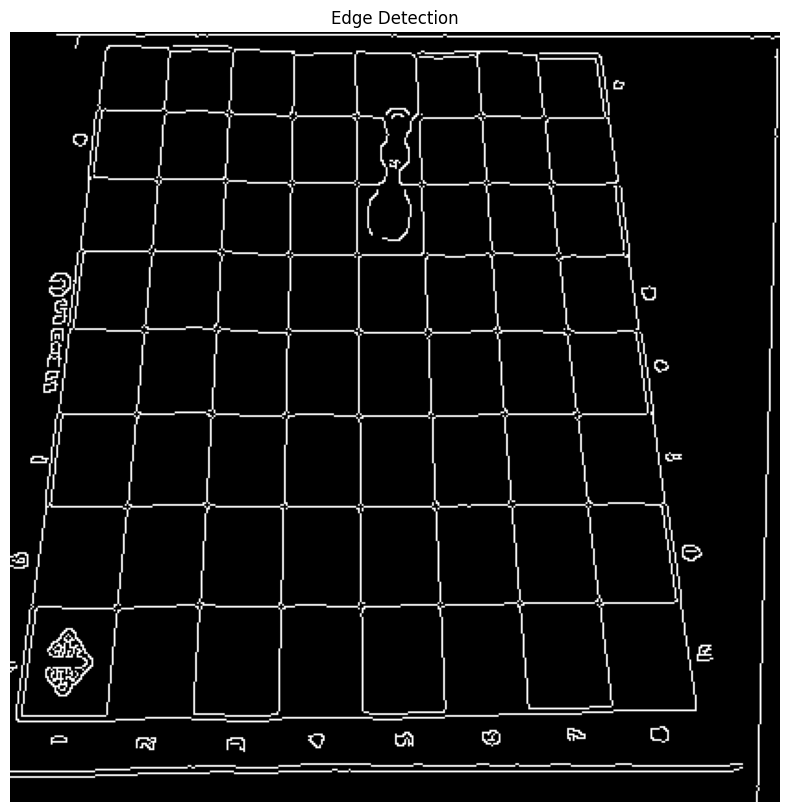

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('/content/drive/MyDrive/Chess scanner Project/Chess_pieces/train/00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.1a1407058a6170f001f2c269411d31d3.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, 50, 150)  # You can experiment with different threshold values

# Show the edge-detected image
plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')
plt.show()


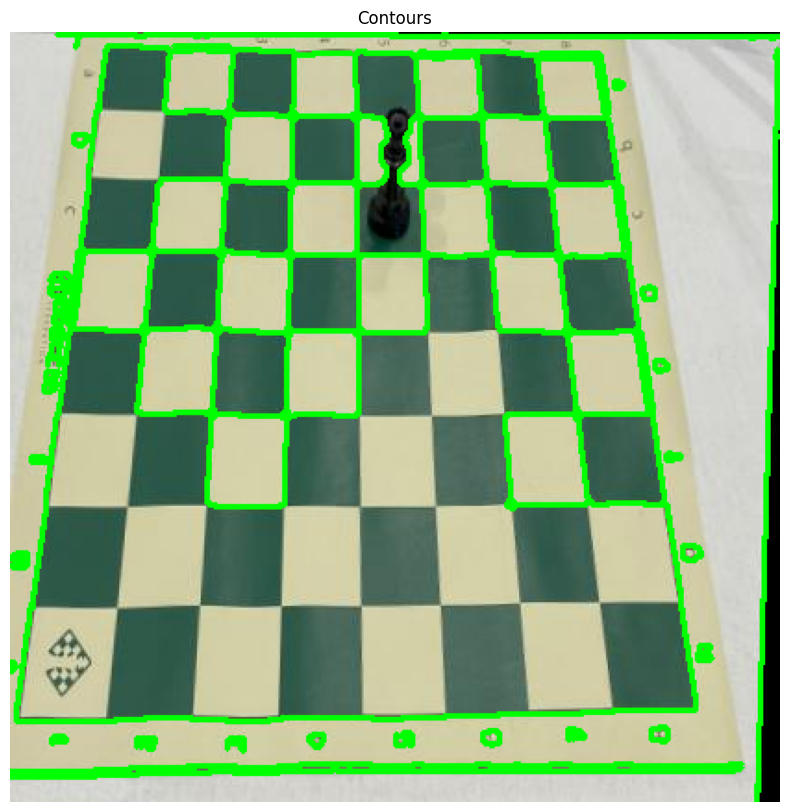

In [ ]:
# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

# Convert BGR to RGB for correct color display in matplotlib
img_contours_rgb = cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)

# Show the image with contours
plt.figure(figsize=(10, 10))
plt.imshow(img_contours_rgb)
plt.title("Contours")
plt.axis('off')
plt.show()


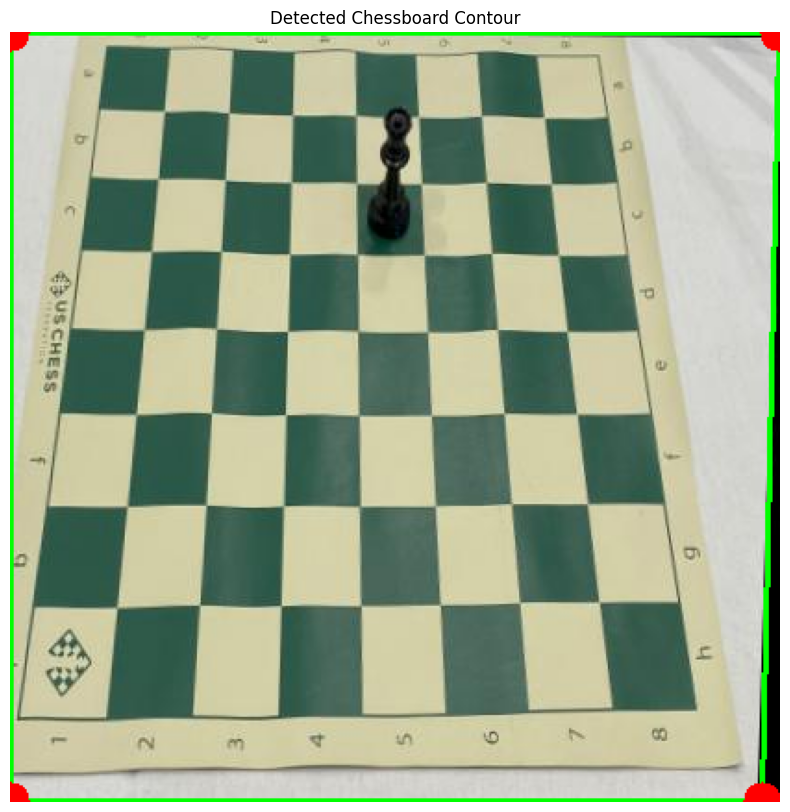

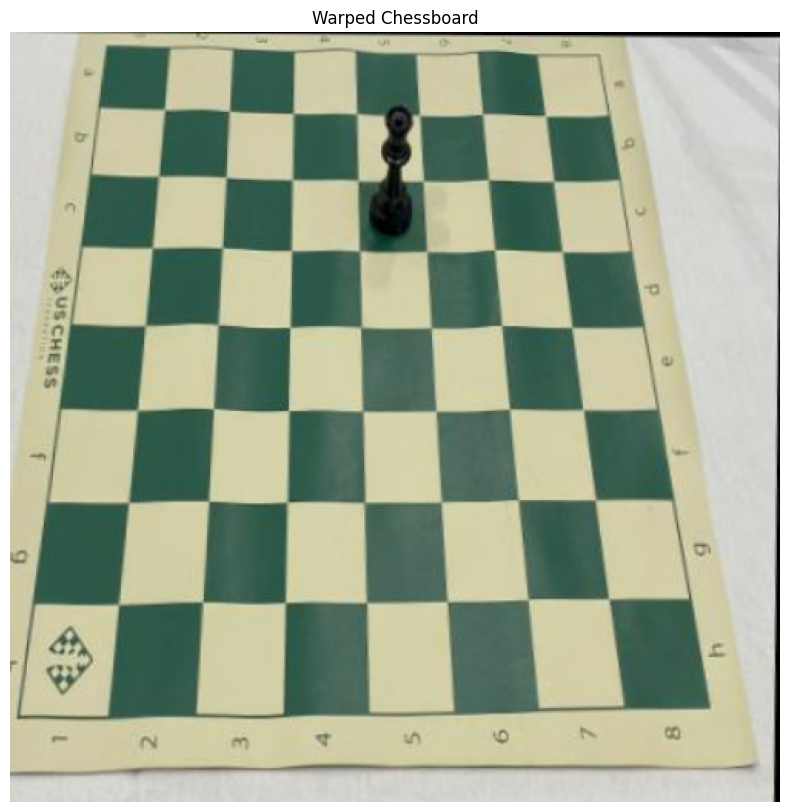

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the image path
image_path = '/content/drive/MyDrive/Chess scanner Project/Chess_pieces/train/00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.1a1407058a6170f001f2c269411d31d3.jpg'

# Load the image
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Increase contrast by histogram equalization
equalized = cv2.equalizeHist(gray)

# Apply a binary threshold to make the chessboard stand out more
_, binary = cv2.threshold(equalized, 127, 255, cv2.THRESH_BINARY)

# Optionally, dilate the binary image to enhance the edges of the chessboard
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(binary, kernel, iterations=2)

# Find contours in the dilated image
contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area to focus on the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Initialize variable to hold the detected chessboard contour
chessboard_contour = None

# Loop over the contours to find the largest quadrilateral
for contour in contours:
    # Approximate the contour to a polygon
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Check if the approximated contour has 4 points (a quadrilateral)
    if len(approx) == 4:
        # We found the chessboard contour (it has 4 points)
        chessboard_contour = approx
        break  # No need to check further contours

# If a chessboard contour is found, proceed with perspective transformation
if chessboard_contour is not None:
    # Draw the detected contour on the original image
    img_contours = img.copy()
    cv2.drawContours(img_contours, [chessboard_contour], -1, (0, 255, 0), 2)

    # Visualize the corners of the detected chessboard
    for point in chessboard_contour:
        cv2.circle(img_contours, tuple(point[0]), 10, (0, 0, 255), -1)

    # Convert to RGB for correct display
    img_contours_rgb = cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)

    # Show the image with the detected corners
    plt.figure(figsize=(10, 10))
    plt.imshow(img_contours_rgb)
    plt.title("Detected Chessboard Contour")
    plt.axis('off')
    plt.show()

    # Order the points of the chessboard for the perspective warp
    ordered_pts = order_points(chessboard_contour.reshape(4, 2))

    # Define the destination points for the top-down view (for example, 500x500 size)
    width, height = 500, 500
    dst_pts = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype='float32')

    # Get the perspective transform matrix
    M = cv2.getPerspectiveTransform(ordered_pts, dst_pts)

    # Warp the image to get the top-down view of the chessboard
    warped_img = cv2.warpPerspective(img, M, (width, height))

    # Convert warped image to RGB for correct display
    warped_img_rgb = cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)

    # Show the warped chessboard
    plt.figure(figsize=(10, 10))
    plt.imshow(warped_img_rgb)
    plt.title("Warped Chessboard")
    plt.axis('off')
    plt.show()

else:
    print("No valid chessboard contour detected.")


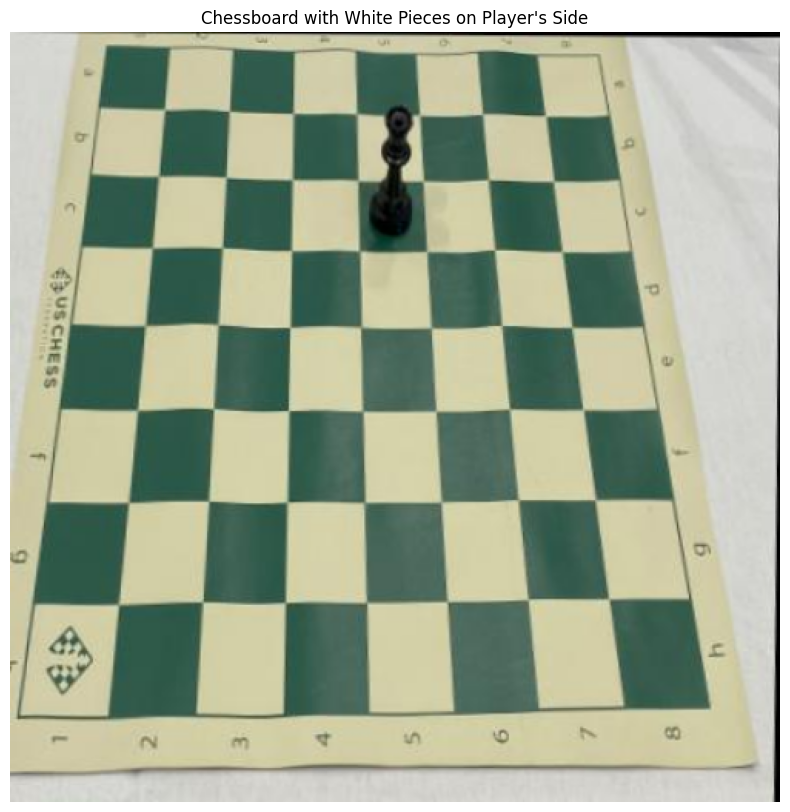

In [ ]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# Function to rotate the image by 180 degrees
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

# Function to detect if the 'a-h' labels are at the top or bottom
def detect_board_orientation(chessboard_img):
    """
    Detects the orientation of the chessboard based on the presence of rank labels ('a-h').
    If the labels are at the top, it returns True (indicating that the chessboard needs to be rotated).
    Otherwise, it returns False.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(chessboard_img, cv2.COLOR_BGR2GRAY)

    # Use OCR to extract text from the bottom part of the image (region of interest)
    height, width = chessboard_img.shape[:2]
    roi_bottom = chessboard_img[int(height * 0.9):, :]  # Take the bottom 10% of the image

    # Use pytesseract to extract text from the bottom region of the image
    extracted_text = pytesseract.image_to_string(roi_bottom, config='--psm 6')

    # Check if 'a' to 'h' appear in the extracted text (the rank labels)
    if any(char in extracted_text for char in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']):
        return False  # This means the rank labels are at the bottom, no rotation needed.
    else:
        return True  # This means the rank labels are at the top, so the board needs to be rotated.

# Function to rotate the chessboard to ensure white pieces are on the player's side
def rotate_chessboard_to_white_side_up(chessboard_img):
    """
    Rotates the chessboard to ensure that white pieces are on the player's side.
    """
    # Detect if the board is upside down based on the rank labels
    needs_rotation = detect_board_orientation(chessboard_img)

    if needs_rotation:
        print("Rotating the chessboard by 180 degrees.")
        rotated_img = rotate_image(chessboard_img, 180)  # Rotate 180 degrees if labels are at the top
    else:
        rotated_img = chessboard_img  # No rotation needed if the board is already in correct orientation

    return rotated_img

# Assuming 'warped_img' is the result of the perspective transformation (top-down view)
warped_img_rgb = cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)

# Rotate the chessboard to ensure white pieces are on the player's side
rotated_chessboard = rotate_chessboard_to_white_side_up(warped_img_rgb)

# Show the rotated chessboard
plt.figure(figsize=(10, 10))
plt.imshow(rotated_chessboard)
plt.title("Chessboard with White Pieces on Player's Side")
plt.axis('off')
plt.show()


In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,190 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,625 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubun